#**$Introduction$**


 
$Project Name:$ Predicting COVID-19 Hospitalizations using Kalman Filter

$Team$ $Members:$ Nitharsan Sivakanthan , Pooja Bhatia

$Problem$ $Statement:$ We want to predict COVID-19 Hospitalizations in Washington State using Kalman filter on the basis of various predictors (positive cases, vaccinations, Age, Cases per county). The Kalman filter is typically used for time series data. We plan to use daily/weekly COVID-19 data to predict hospitalizations. 

In research papers we found, there was promise in using the Kalman filter for time series forecasting to determine trends in the COVID-19 pandemic. These papers also included a possibility in studying the association of vaccinated people and number of daily cases for predictions, which is exactly what we are planning to use.



# **$Implementatin$ $of$ $Kalman$ $filter$ $for$ $predecting$ $Hospitalisations$ $due$ $to$ COVID-19 $using$ $Python$**

Importing all libraries


In [258]:
!pip install pykalman -q

In [259]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats, special
import seaborn as sns 
sns.set_style("whitegrid")
from numpy.linalg import inv
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data Preparation

We have used the data from ------- and uploaded it to github . 
There are 4 datasets. 
1. Number of cases 
2. Number of vaccinations
3. Number of deaths
4. Number of hosptilazations
All the datasets have daily reported  cummulative count.


In [260]:
# create dataframes from CSV's
cases = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative_Cases.csv')
vac = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Vaccinations.csv')
death = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Deaths.csv')
hosp = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Hospitalizations.csv')

The 4 datasets above are now joined on date to convert into a single table (dataframe).

In [261]:
# combine into one dataframe
Covid_data = hosp.join(cases.set_index('Date'), on='Date').join(vac.set_index('Date'), on='Date').join(death.set_index('Date'), on='Date')

Displaying top 15 rows to verify the format of dataset. 

In [262]:
Covid_data.head(15)

,Date,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths
0,2/25/2020,1092,0,1,NaN,2
1,2/26/2020,1094,0,1,NaN,4
2,2/27/2020,1105,0,1,NaN,4
3,2/28/2020,1114,0,1,NaN,6
4,2/29/2020,1121,0,1,NaN,7
5,3/1/2020,1129,0,1,NaN,10
6,3/2/2020,1150,13,14,NaN,13
7,3/3/2020,1162,16,30,NaN,16
8,3/4/2020,1176,15,45,NaN,18
9,3/5/2020,1203,21,66,NaN,23


Since, we have daily number of cases in our dataset, but we do not have daily numbers for hospitalisation, vaccines and death, we are computing the numbers using diff function. It calculates the difference in previous and current row. 

In [263]:
# create columns for daily counts, cases already has one
Covid_data['Hospitalizations_Daily'] = Covid_data['Hospitalizations'].diff()
Covid_data['Vaccines_Daily'] = Covid_data['Vaccines'].diff()
Covid_data['Deaths_Daily'] = Covid_data['Deaths'].diff()

Introducting a time column to generate the number of days since Covid-19 started.

In [264]:
# add a time column
Covid_data['Time'] = np.arange(len(Covid_data.index))

Displaying the information of Covid_data table.

In [265]:
# check NA values do to nature of data can set NA values to 0
Covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    703 non-null    object 
 1   Hospitalizations        703 non-null    int64  
 2   New Cases Reported      703 non-null    int64  
 3   Cases                   703 non-null    int64  
 4   Vaccines                407 non-null    float64
 5   Deaths                  703 non-null    int64  
 6   Hospitalizations_Daily  702 non-null    float64
 7   Vaccines_Daily          406 non-null    float64
 8   Deaths_Daily            702 non-null    float64
 9   Time                    703 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 55.0+ KB


From above we see that there are nulls in few columns, filling in the null using fill.na().


In [266]:
Covid_data = Covid_data.fillna(0)
Covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    703 non-null    object 
 1   Hospitalizations        703 non-null    int64  
 2   New Cases Reported      703 non-null    int64  
 3   Cases                   703 non-null    int64  
 4   Vaccines                703 non-null    float64
 5   Deaths                  703 non-null    int64  
 6   Hospitalizations_Daily  703 non-null    float64
 7   Vaccines_Daily          703 non-null    float64
 8   Deaths_Daily            703 non-null    float64
 9   Time                    703 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 55.0+ KB


In [267]:
Covid_data.head(15)

,Date,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths,Hospitalizations_Daily,Vaccines_Daily,Deaths_Daily,Time
0,2/25/2020,1092,0,1,0.0,2,0.0,0.0,0.0,0
1,2/26/2020,1094,0,1,0.0,4,2.0,0.0,2.0,1
2,2/27/2020,1105,0,1,0.0,4,11.0,0.0,0.0,2
3,2/28/2020,1114,0,1,0.0,6,9.0,0.0,2.0,3
4,2/29/2020,1121,0,1,0.0,7,7.0,0.0,1.0,4
5,3/1/2020,1129,0,1,0.0,10,8.0,0.0,3.0,5
6,3/2/2020,1150,13,14,0.0,13,21.0,0.0,3.0,6
7,3/3/2020,1162,16,30,0.0,16,12.0,0.0,3.0,7
8,3/4/2020,1176,15,45,0.0,18,14.0,0.0,2.0,8
9,3/5/2020,1203,21,66,0.0,23,27.0,0.0,5.0,9


We now have the data in the required form for further analysis.

# Data Exploration

## Plots of variables over time
Scatterplot of number of hospitalizations reported daily

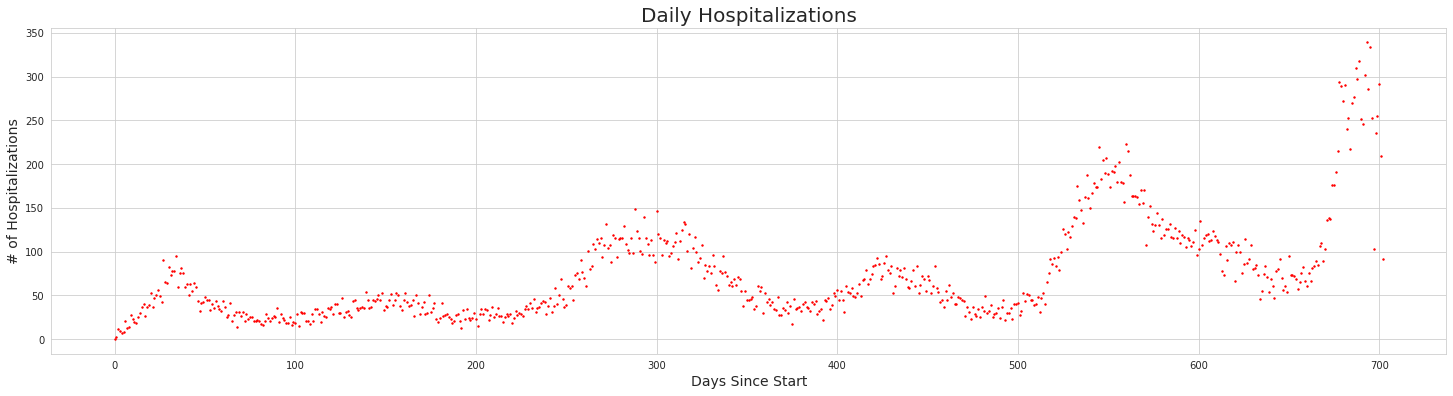

In [268]:
plt.figure(figsize=(25,6))
plt.scatter(Covid_data['Time'], Covid_data['Hospitalizations_Daily'], color='red', s = 2)
plt.title('Daily Hospitalizations', fontsize=20)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()

Scatterplot of number of cases reported daily

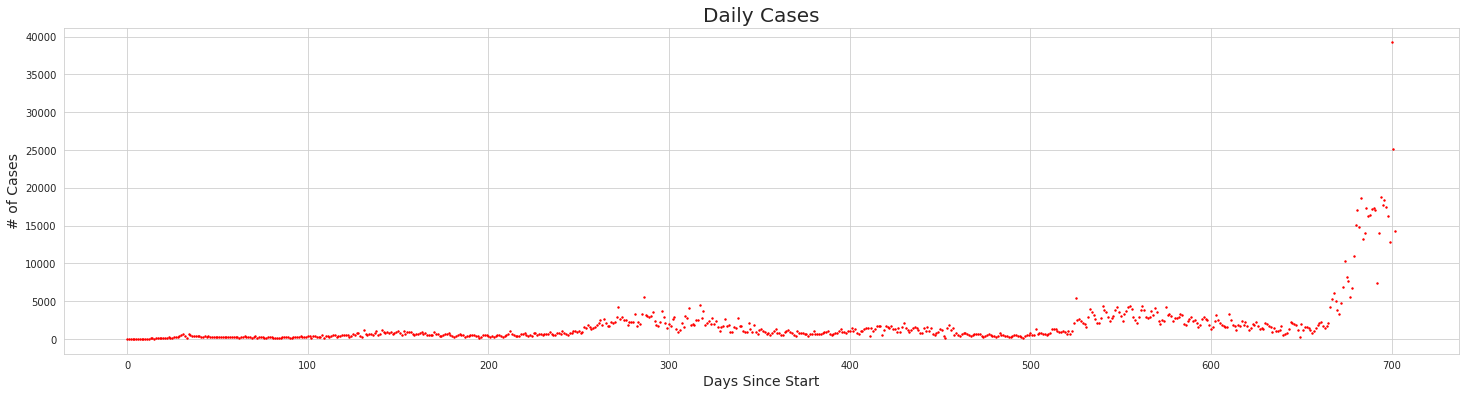

In [269]:
plt.figure(figsize=(25,6))
plt.scatter(Covid_data['Time'], Covid_data['New Cases Reported'], color='red', s= 2)
plt.title('Daily Cases', fontsize=20)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Cases', fontsize=14)
plt.grid(True)
plt.show()

Scatterplot of number of deaths reported daily

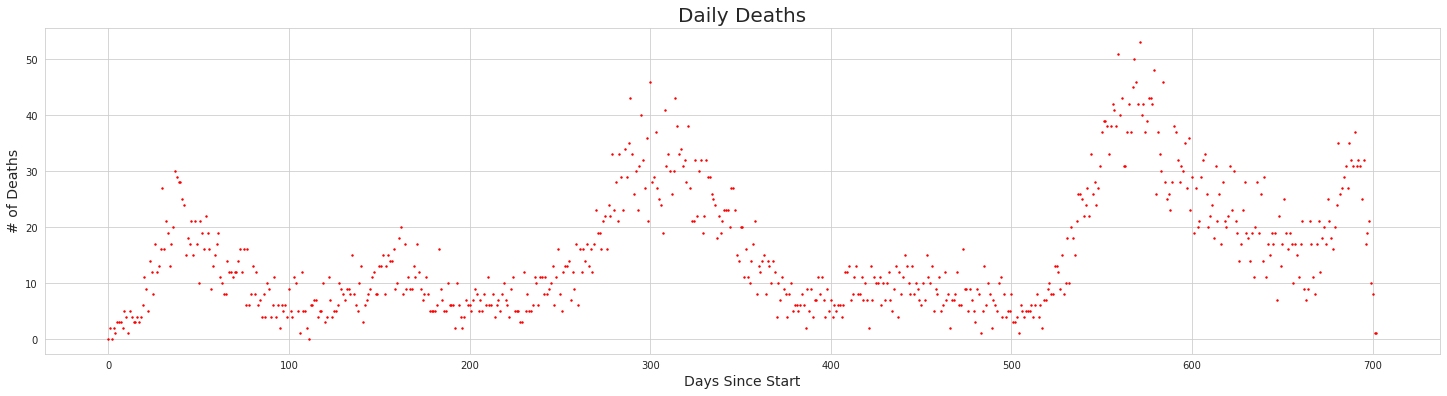

In [270]:
plt.figure(figsize=(25,6))
plt.scatter(Covid_data['Time'], Covid_data['Deaths_Daily'], color='red', s = 2)
plt.title('Daily Deaths', fontsize=20)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Deaths', fontsize=14)
plt.grid(True)
plt.show()

Scatterplot of number of Vaccinations reported daily

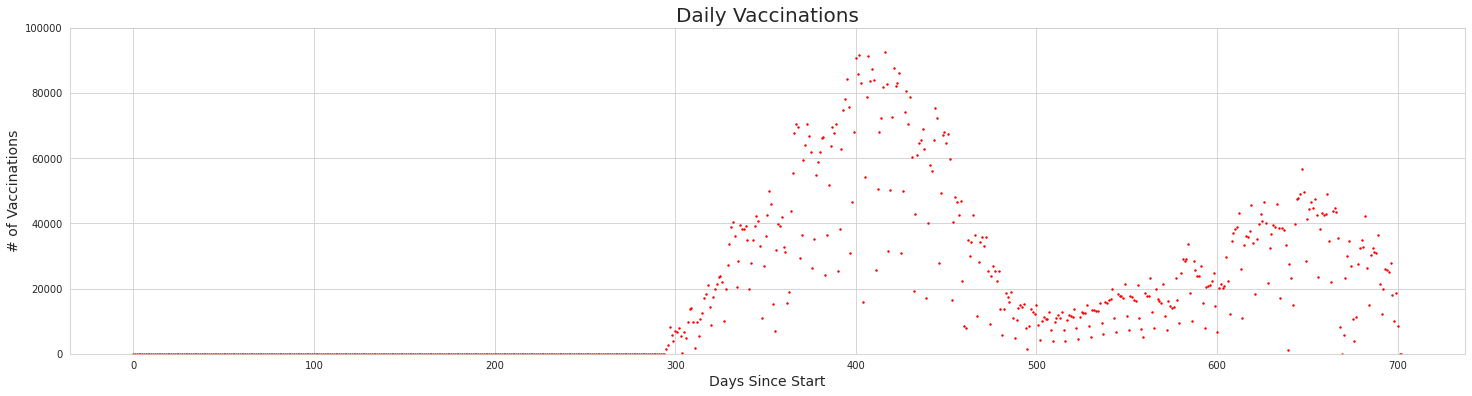

In [271]:
plt.figure(figsize=(25,6))
plt.scatter(Covid_data['Time'], Covid_data['Vaccines_Daily'], color='red', s = 2)
plt.title('Daily Vaccinations', fontsize=20)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Vaccinations', fontsize=14)
plt.grid(True)
plt.ylim(0,100000)
plt.show()

## Multiple Linear Regression

###Fitting Multiple linear regression to our data to see how it fits.

Spliting the dataset into Train(80%) and Test(20%) data.

In [272]:
X = Covid_data[['New Cases Reported','Deaths_Daily','Vaccines_Daily','Time']]
Y = Covid_data[['Hospitalizations_Daily']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

Creating a linear model on training data to generate intercept and coefficients.

In [273]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [2.90731633]
Coefficients: 
 [[ 9.39427070e-03  2.19708750e+00 -1.11998019e-04  6.54614416e-02]]


Training score:

In [274]:
print("Training Score: " ,round(reg.score(x_train,y_train)*100,1), "%")

Training Score:  82.0 %


Testing Score:

In [275]:
print("Testing Score: " ,round(reg.score(x_test,y_test)*100,1), "%")

Testing Score:  78.8 %


Fetching the residuals

In [276]:
y_predicted = reg.predict(x_test)
resid = y_test - y_predicted

Scatterplot of Residuals 

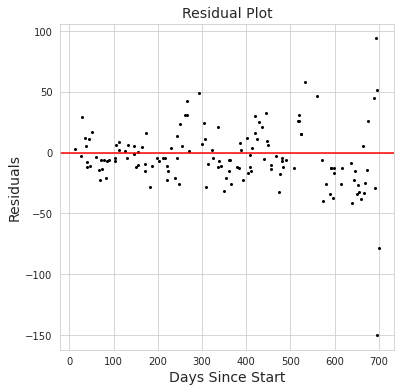

In [277]:
plt.figure(figsize=(6,6))
plt.scatter(x_test['Time'], resid, color='black', s= 4)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(True)
plt.show()

Scatterplot of predicted daily hospitalizations versus reported daily hospitalizations 

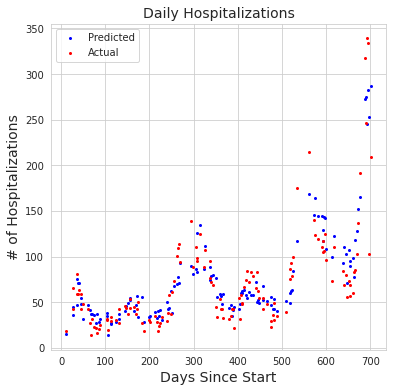

In [278]:
plt.figure(figsize=(6,6))
plt.scatter(x_test['Time'], reg.predict(x_test), color='blue', s= 4)
plt.scatter(x_test['Time'], y_test['Hospitalizations_Daily'], color = 'red', s =4)
plt.legend(['Predicted','Actual'])
plt.title('Daily Hospitalizations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()

# Kalman Filter without control

we can write our state equations as :
$$\mathbf{x}_{k+1} = A_k\mathbf{x}_{k} + B_k\mathbf{u}_k + \mathbf{w}_k$$
$$\mathbf{y}_k = C_k\mathbf{x}_k + \mathbf{v}_k$$

$$\mathbf{x}_k = \begin{bmatrix}h_k \\ h'_k\end{bmatrix}$$

\begin{align}
h(t + \Delta t) &= h(t) + \Delta th'(t) + \text{error} \\ \\
\end{align}

\begin{align}
h'(t + \Delta t) &= h'(t) + \Delta th''(t) + \text{error}  \\ \\
&= h'(t)  \text + {error}  
\end{align}

\\

$$\mathbf{x}_{k+1} = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}\mathbf{x}_{k} + \begin{bmatrix}0\\ 0\end{bmatrix}u_{k} + \mathbf{w}_k$$

where $u_{k} = a_{k}$ and $\mathbf{w}_k$ is a noise term.

\\
$$y_k = \begin{bmatrix}1 & 0\end{bmatrix}\mathbf{x}_{k} + \mathbf{v}_k$$
where $\mathbf{v}_k$ is a noise term.


In this model, the matrices are constant and given by:

$$A = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}$$

\\

$$B = \begin{bmatrix}0\\ 0\end{bmatrix}$$

\\

$$C = \begin{bmatrix}1 & 0\end{bmatrix}$$

#### Time

Creating timesteps :  dt : 1 day

number of steps : n_timesteps = len of dataset 

t : n_timesteps * dt

In [279]:
#Time step
dt = 1

#Number of time steps
n_timesteps = len(Covid_data['Time'])

#Time
t = np.arange(n_timesteps)*dt

#### Matrices

Define the matrices $A$, $B$, and $C$.

In [280]:
A = np.array([[1, dt],
             [0, 1]])

B = np.array([[0],[0]])

C = np.array([[1, 0]])

#Use these matrices to determine the dimensions of the state and observation vectors
n_dim_state = A.shape[0]

n_dim_obs = C.shape[0]

#### Control Signal

Unsure of what the control signal is in this application we will start without one.

Get an array of zeros with proper length

In [281]:
u = np.ones((1,n_timesteps))

In [282]:
b = np.matmul(B,u)

In [283]:
b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Noise distributions

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [284]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = [[1000,0.0],[0.0,45]]

#Create the random variable 
state_noise = stats.multivariate_normal(state_mean_vec, state_cov_matrix)

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [285]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = 2810

#Create the random variable 
obs_noise = stats.norm(loc = obs_mean, scale = obs_std)

#### Use the Kalman filter to estimate the states

Create the observations

In [286]:
y = Covid_data['Hospitalizations']

Define a Kalman filter object with the known properties of the system

In [287]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [288]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter.

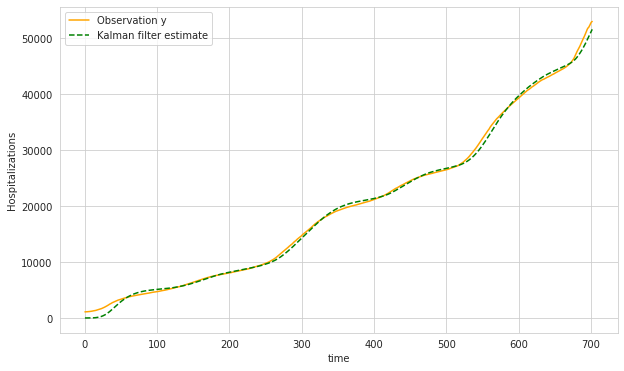

In [289]:
#Plot position
plt.figure(figsize = (10,6))
plt.plot(t,y, color = 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observation y', 'Kalman filter estimate'])


Plot differences in y and Kalman filter estimate

Text(0, 0.5, 'Residuals')

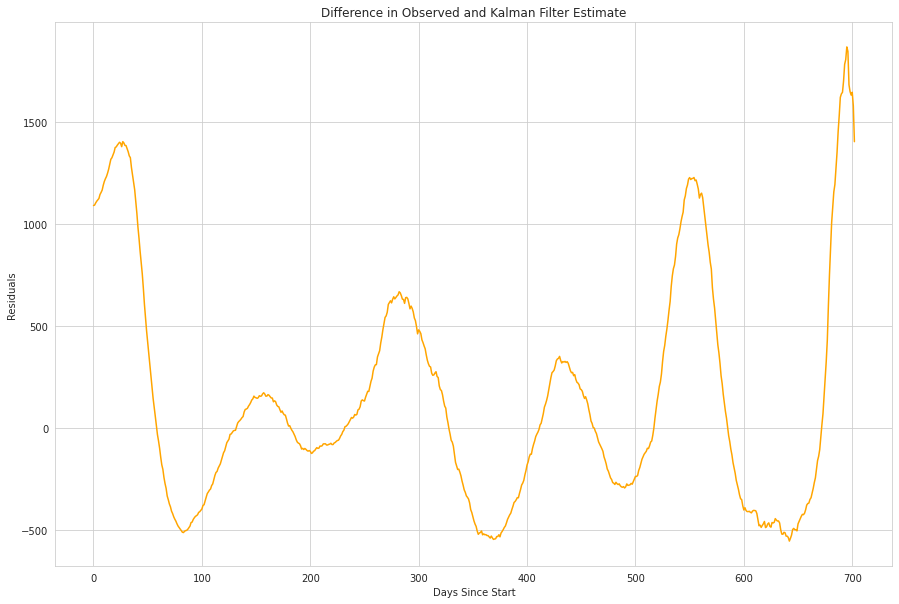

In [290]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')

#### Learning model parameters

Suppose that we only have guesses for the noise covariances.

In [291]:
state_cov_matrix_guess = [[1000,0.0],[0.0,45]]

obs_std_guess = 2810.

We can define a `KalmanFilter` object with the guessed values and indicate that we want to use the EM algorithm to learn those parameters using `em_vars=['transition_covariance', 'observation_covariance']`

In [292]:
kf_learn = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix_guess, observation_covariance=obs_std_guess**2, transition_offsets=b.T, em_vars=['transition_covariance', 'observation_covariance'])

Applying the method `.em` uses the EM algorithm to estimate those parameters based on the observed data.

In [293]:
kf_learn = kf_learn.em(y, n_iter = 10)

Compare the learned values to the true values. This is a difficult optimization problem, so the estimates will not be perfect.

In [294]:
print('EM estimate of state covariance = ', kf_learn.transition_covariance, '. True covariance = ', state_cov_matrix)

EM estimate of state covariance =  [[1971.77474165  143.92924863]
 [ 143.92924863   60.38406785]] . True covariance =  [[1000, 0.0], [0.0, 45]]


In [295]:
print('EM estimate of observation variance = ', kf_learn.observation_covariance, '. True variance = ', obs_std**2)

EM estimate of observation variance =  [[3530.56660864]] . True variance =  7896100


#### Use Estimated values to Update Kalman Filter

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [296]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = kf_learn.transition_covariance

#Create the random variable 
state_noise = stats.multivariate_normal(state_mean_vec, state_cov_matrix)

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [297]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = np.sqrt(kf_learn.observation_covariance)

#Create the random variable 
obs_noise = stats.norm(loc = obs_mean, scale = obs_std)

#### Use the Kalman filter to estimate the states with the estimated optimal parameters

Define a Kalman filter object with the known properties of the system

In [298]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [299]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter.

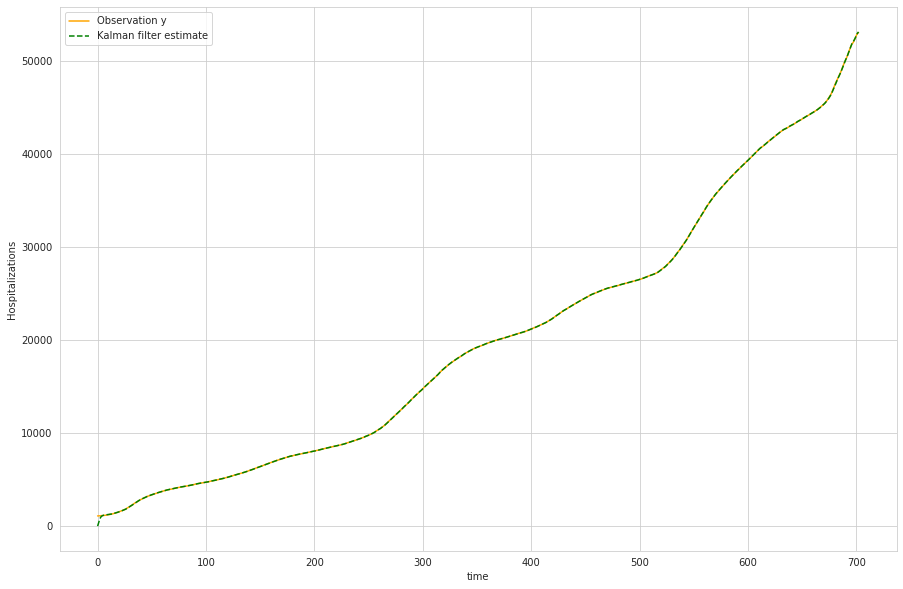

In [300]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y,color = 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observation y', 'Kalman filter estimate'])


Plot differences in y and Kalman filter estimate

Text(0, 0.5, 'Residuals')

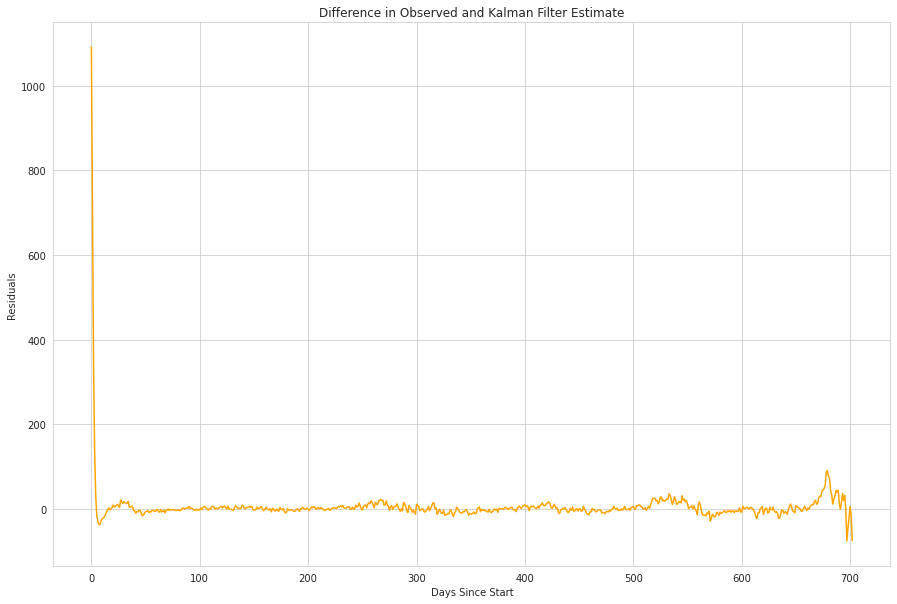

In [301]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')

Plot zoomed in on later values

(400.0, 737.1)

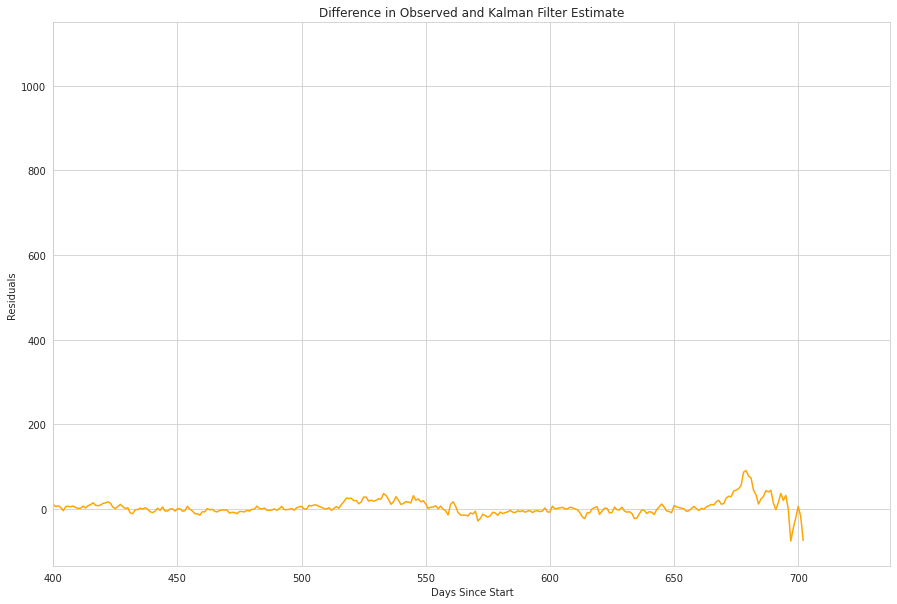

In [302]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')
plt.xlim(400)
#plt.ylim(ymin = -100, ymax =100)

# Kalman Filter with control estimate

#### Matrices

Define new matrix $B$.

In [303]:
B = np.array([[.5* dt**2],[dt]])

#### Control Signal

We will estimate the control signal using linear regression

In [304]:
X = Covid_data[['Time']]
Y = Covid_data[['Hospitalizations_Daily']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

In [305]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [12.24362896]
Coefficients: 
 [[0.17723588]]


Get an array with proper length

In [306]:
u = .175*np.ones((1,n_timesteps))

In [307]:
b = np.matmul(B,u)

In [308]:
b

array([[0.0875, 0.0875, 0.0875, ..., 0.0875, 0.0875, 0.0875],
       [0.175 , 0.175 , 0.175 , ..., 0.175 , 0.175 , 0.175 ]])

#### Noise distributions

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [309]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = [[1000,0.0],[0.0,45]]

#Create the random variable 
state_noise = stats.multivariate_normal(state_mean_vec, state_cov_matrix)

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [310]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = 2810

#Create the random variable 
obs_noise = stats.norm(loc = obs_mean, scale = obs_std)

#### Use the Kalman filter to estimate the states

Create the observations

In [311]:
y = Covid_data['Hospitalizations']

Define a Kalman filter object with the known properties of the system

In [312]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [313]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter.

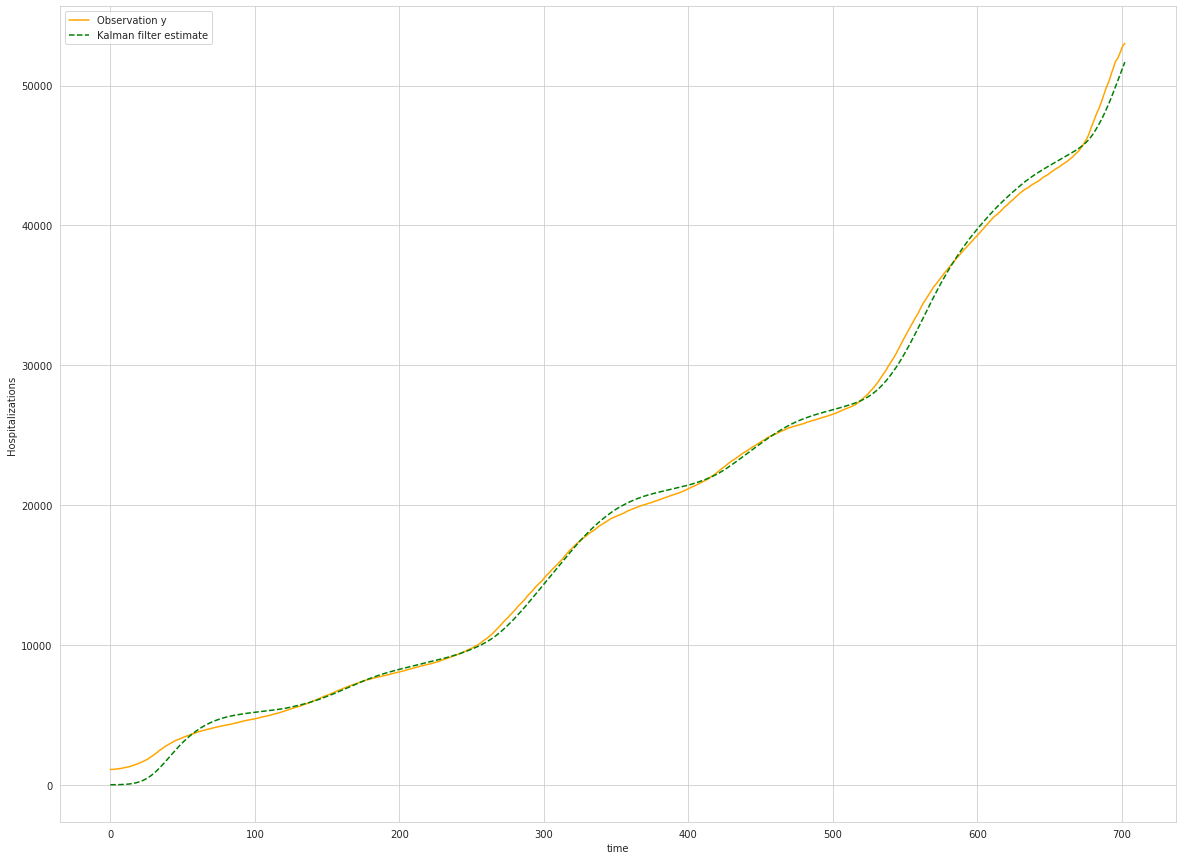

In [314]:
#Plot position
plt.figure(figsize = (20,15))
plt.plot(t,y, color = 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observation y', 'Kalman filter estimate'])


Plot differences in y and Kalman filter estimate

Text(0, 0.5, 'Residuals')

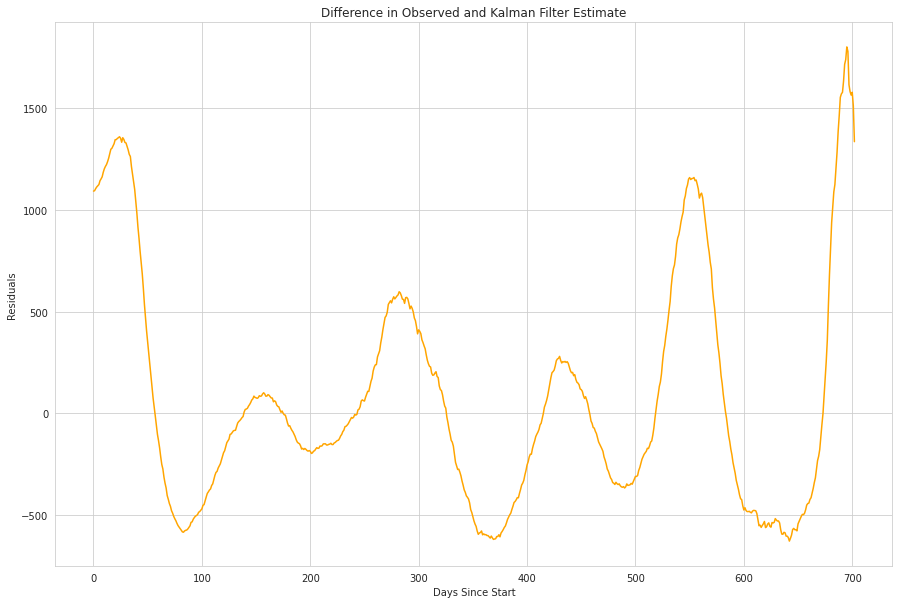

In [315]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')

#### Learning model parameters

Suppose that we only have guesses for the noise covariances.

In [316]:
state_cov_matrix_guess = [[1000,0.0],[0.0,45]]

obs_std_guess = 2810.

We can define a `KalmanFilter` object with the guessed values and indicate that we want to use the EM algorithm to learn those parameters using `em_vars=['transition_covariance', 'observation_covariance']`

In [317]:
kf_learn = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix_guess, observation_covariance=obs_std_guess**2, transition_offsets=b.T, em_vars=['transition_covariance', 'observation_covariance'])

Applying the method `.em` uses the EM algorithm to estimate those parameters based on the observed data.

In [318]:
kf_learn = kf_learn.em(y, n_iter = 10)

Compare the learned values to the true values. This is a difficult optimization problem, so the estimates will not be perfect.

In [319]:
print('EM estimate of state covariance = ', kf_learn.transition_covariance, '. True covariance = ', state_cov_matrix)

EM estimate of state covariance =  [[1972.26953818  141.55708599]
 [ 141.55708599   59.57618908]] . True covariance =  [[1000, 0.0], [0.0, 45]]


In [320]:
print('EM estimate of observation variance = ', kf_learn.observation_covariance, '. True variance = ', obs_std**2)

EM estimate of observation variance =  [[3530.93376998]] . True variance =  7896100


#### Use Estimated values to Update Kalman Filter

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [321]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = kf_learn.transition_covariance

#Create the random variable 
state_noise = stats.multivariate_normal(state_mean_vec, state_cov_matrix)

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [322]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = np.sqrt(kf_learn.observation_covariance)

#Create the random variable 
obs_noise = stats.norm(loc = obs_mean, scale = obs_std)

#### Use the Kalman Filter to estimate the states with the estimated optimal model parameters

Define a Kalman filter object with the known properties of the system

In [323]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [324]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter.

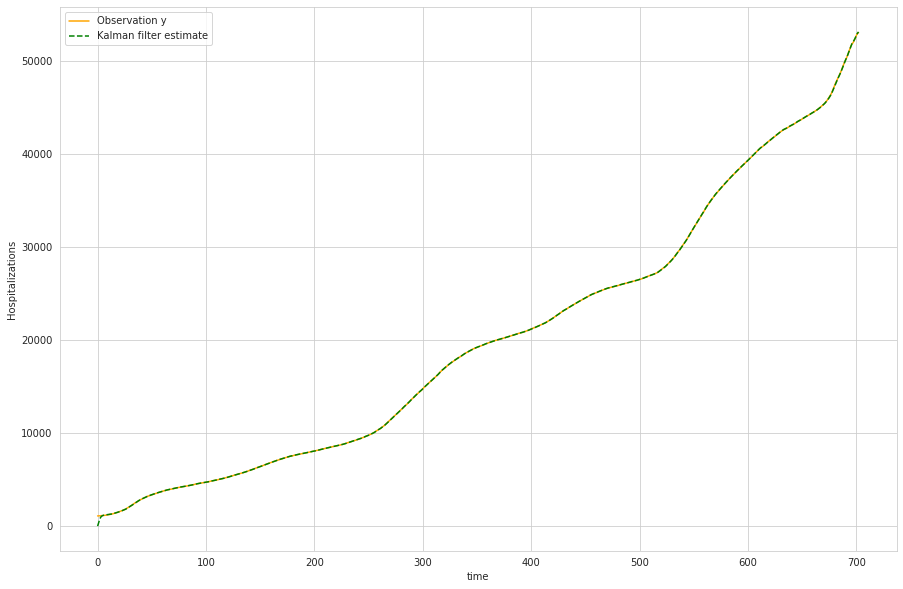

In [325]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y,color = 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observation y', 'Kalman filter estimate'])


Plot differences in y and Kalman filter estimate

Text(0, 0.5, 'Residuals')

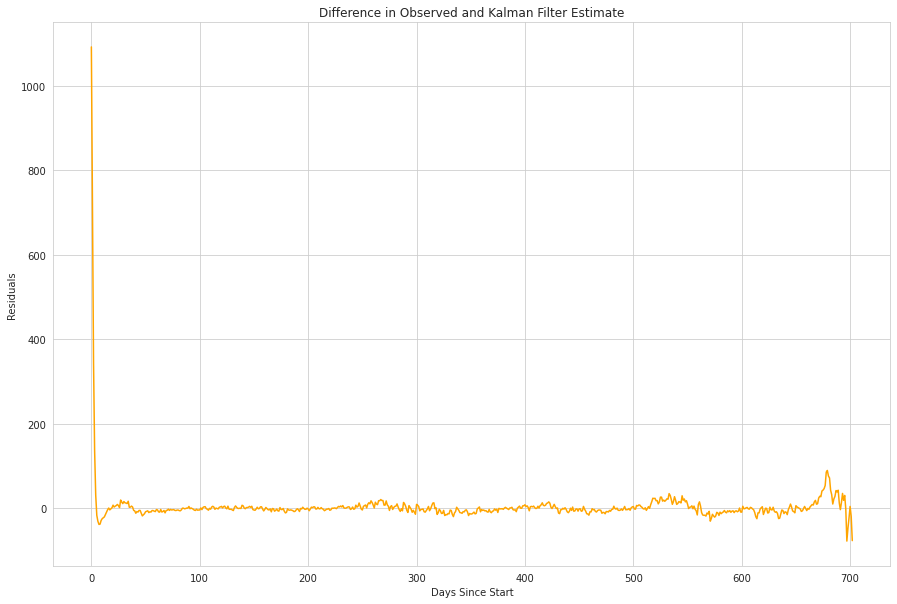

In [326]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')

Plot zoomed in on later values

(-100.0, 100.0)

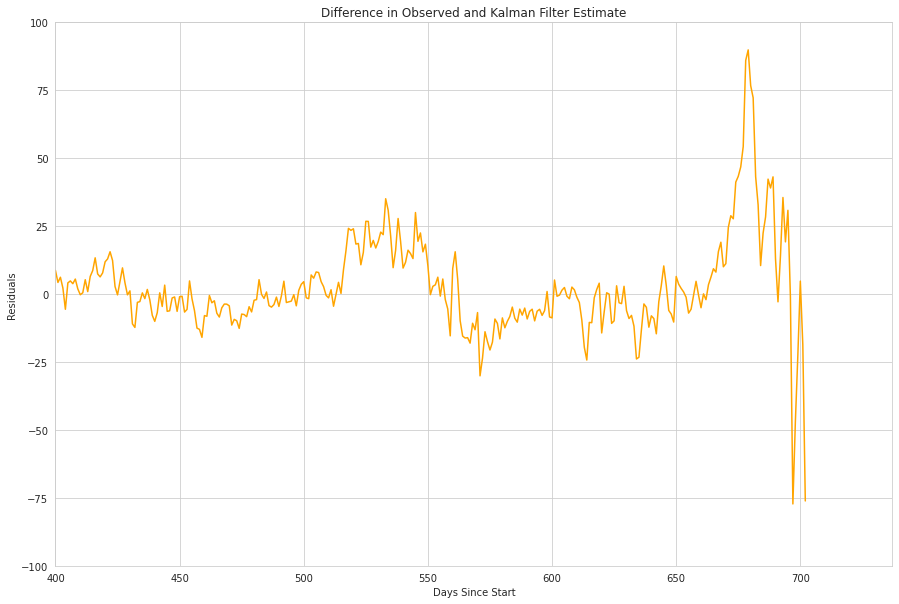

In [327]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')
plt.xlim(400)
plt.ylim(ymin = -100, ymax =100)